# 20 vs 20 signal processing

## 2 ways to process signal
* Based on exact tags count using fragment size
    UNIQUE_BAM -> PILEUP_BED -> TAGS -> intersect with given regions bed and compute intersection
* Based on bigwigs
    UNIQUE_BAM -> BIGWIG -> bigWigAverageOverBed
    
### Create TAGS

```
# Create unique bams 
./gradlew integration:shadowJar && java -cp integration/build/libs/integration-dev.jar org.jetbrains.bio.experiments.histones.UniqueBamsExperiment Y20O20 

# Create TAGs
cd /mnt/stripe/bio/experiments/configs/Y20O20/unique
for D in $(ls . | grep -v yaml); do 
    echo $(pwd)/$D; 
    bash /mnt/stripe/washu/parallel/tags_bigwig.sh /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes 150 $(pwd)/$D 
done
```

## Interesting LOCI
* All merged `/mnt/stripe/bio/raw-data/aging/loci_of_interest/`

# Prepare BigWigs
```
# Prepare data
for M in H3K27ac H3K27me3 H3K36me3 H3K4me1 H3K4me3; do 
    echo $M; 
    mkdir $M; 
    ls /mnt/stripe/bio/experiments/configs/Y20O20/unique_tags_bw/$M/*.bw | xargs -I {} ln -s {} $M/; 
    # In case we have input separated processed
    # ls /mnt/stripe/bio/experiments/configs/Y20O20/unique_tags_bw/input/*.bw xargs -I {} ln -s {} $M/;
done
```

# All histone modifications
```
mkdir -p /mnt/stripe/bio/experiments/signal_all_modifications
cd /mnt/stripe/bio/experiments/signal_all_modifications

# Union all the median peaks
bash /mnt/stripe/washu/bed/union.sh /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K27ac_macs2_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K27me3_zinbra_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K36me3_zinbra_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K4me1_zinbra_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K4me3_zinbra_median_consensus.bed > median_consensus_union.bed


# Prepare BigWigs and place them inside single folder
mkdir -p all
mv */*.bw all/
cd all/
bash /mnt/stripe/washu/parallel/signals_bw.sh $(pwd) ../median_consensus_union.bed median_consensus_union /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes
```

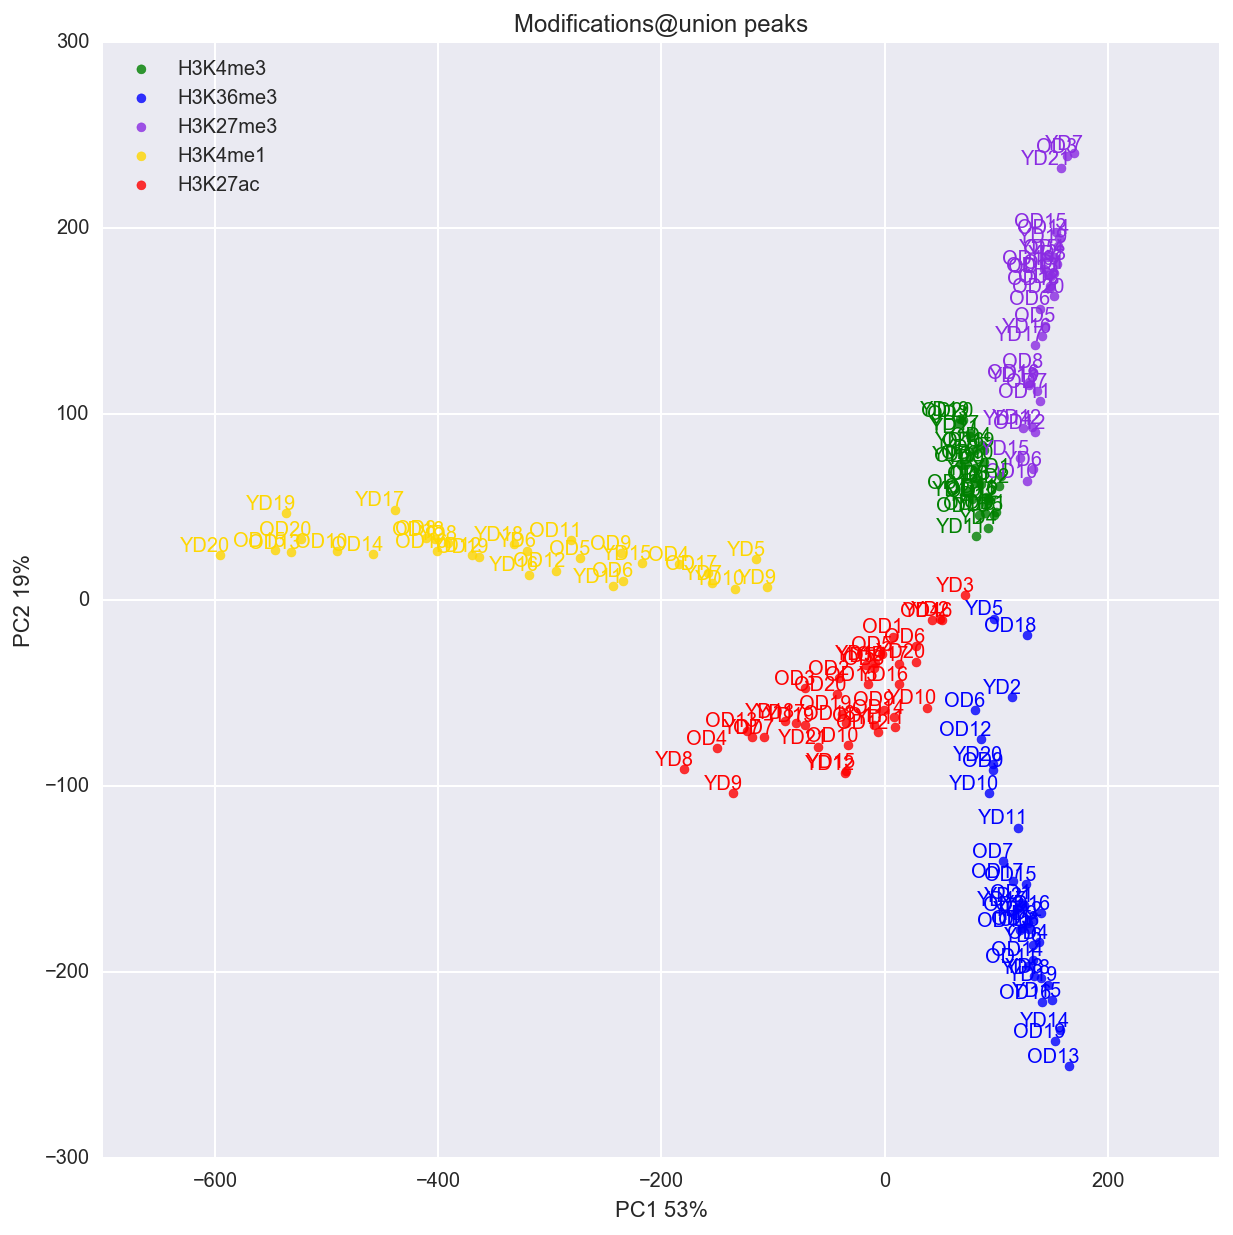

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import re
import matplotlib
import pandas as pd

# Import from washu 
from scripts.signals_visualize import signal_pca
from scripts.util import *

import matplotlib.pyplot as plt  # nopep8
import seaborn as sns  # nopep8

# Explicitly setup style
plt.style.use('seaborn-darkgrid')

df = pd.read_csv('/mnt/stripe/bio/experiments/signal_all_modifications/all/\
median_consensus_union/median_consensus_union_rpm.tsv', sep='\t')
od_inputs = [c for c in df.columns.values if is_od_input(c)]
yd_inputs = [c for c in df.columns.values if is_yd_input(c)]
signal = df.drop(['chr', 'start', 'end', od_inputs[0], yd_inputs[0]], axis=1).T

Group = namedtuple('Group', 'name color prefix')
H3K27ac = Group('H3K27ac', 'red', '')
H3K27me3 = Group('H3K27me3', 'blueviolet', '')
H3K36me3 = Group('H3K36me3', 'blue', '')
H3K4me1 = Group('H3K4me1', 'gold', '')
H3K4me3 = Group('H3K4me3', 'green', '')
Meth = Group('Meth', 'black', '')

def group(x):
    if re.match('.*K27ac.*', x):
        return H3K27ac
    if re.match('.*K27me3.*', x):
        return H3K27me3
    if re.match('.*K36me3.*', x):
        return H3K36me3
    if re.match('.*K4me1.*', x):
        return H3K4me1
    if re.match('.*K4me3.*', x):
        return H3K4me3
    
groups = [group(r) for r in signal.index]
plt.figure(figsize=(10, 10))
signal_pca(signal, 'Modifications@union peaks', groups=groups, scaled=True, fit_lr=False)
plt.legend(loc='upper left')
plt.show()

# Process signals, build PCA, launch tests
```
export PYTHONPATH="/mnt/stripe/washu:$PYTHONPATH"
export WASHU_PARALLELISM=20
DIR=$(pwd)
for M in H3K27ac H3K27me3 H3K36me3 H3K4me1 H3K4me3 meth; do
    echo "Processing $M"; 
    PEAKS=$(ls /mnt/stripe/bio/raw-data/aging/loci_of_interest/weak_consensus/${M}_zinbra_weak_consensus.bed)
    echo "Peaks $PEAKS"
    BEDS=$(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/ -name "*.bed" | grep -vE 'repeats|other')  
    BEDSL=$(echo "$BEDS" | wc -l)  
    I=1 
    for BED in ${BEDS[@]}; do 
        echo "$I/$BEDSL"; I=$(($I+1));
        bash /mnt/stripe/washu/parallel/signals_bw.sh $DIR/$M $BED /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes $PEAKS
    done
done | tee log.txt

# Create report
bash /mnt/stripe/washu/reports/signals_report.sh $(pwd) $(pwd)/report.tsv
```